In [1]:
import graphviz
from sklearn import tree
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.datasets import load_iris

In [2]:
iris = load_iris()

In [3]:
clf = tree.DecisionTreeClassifier()

In [4]:
clf = clf.fit(iris.data, iris.target)

In [9]:
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
# graph.render("iris", view=True) 

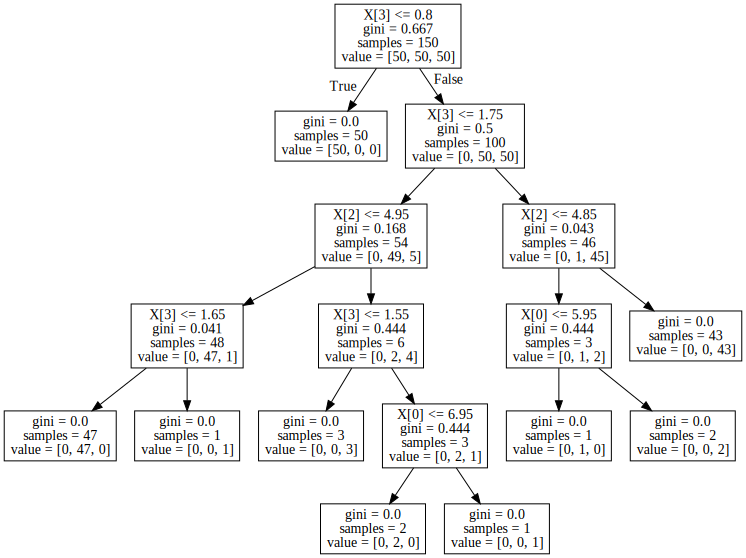

In [10]:
graph

In [11]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

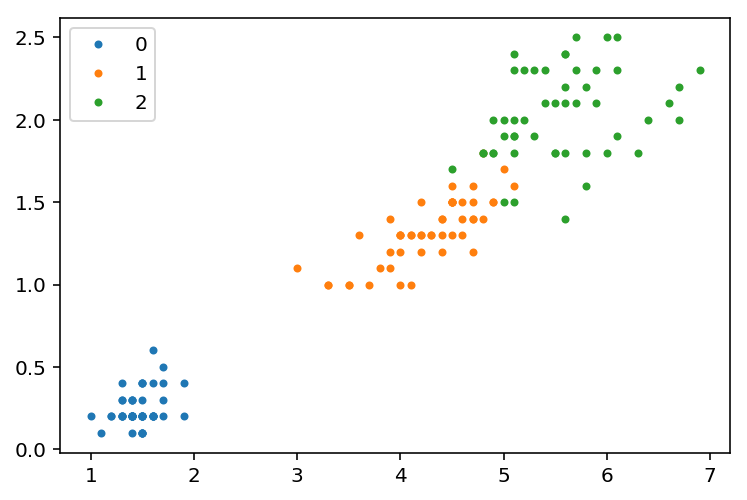

In [12]:
plt.plot(iris.data[iris.target == 0, 2], iris.data[iris.target == 0, 3], '.', label='0')
plt.plot(iris.data[iris.target == 1, 2], iris.data[iris.target == 1, 3], '.', label='1')
plt.plot(iris.data[iris.target == 2, 2], iris.data[iris.target == 2, 3], '.', label='2')
plt.legend();

In [13]:
import pandas as pd

In [14]:
data = pd.read_csv('../kaggle_odessa/notebooks/titanic/train.csv')

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [17]:
from sklearn.model_selection import train_test_split, StratifiedKFold

In [18]:
train, holdout = train_test_split(data, test_size=.1, random_state=42)

In [22]:
y = train.Survived.values

In [67]:
X = train[['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Pclass']]

In [50]:
ohe_embarked = pd.get_dummies(X['Embarked'], prefix='embarked')
X = X.drop('Embarked', axis=1)
X = pd.concat([X, ohe_embarked], axis=1)

ohe_pclass = pd.get_dummies(X['Pclass'], prefix='pclass')
X = X.drop('Pclass', axis=1)
X = pd.concat([X, ohe_pclass], axis=1)

In [60]:
X.loc[X.Age.isna(), 'Age'] = X.Age.mean()

In [63]:
X.columns.values

array(['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'embarked_C', 'embarked_Q',
       'embarked_S', 'pclass_1', 'pclass_2', 'pclass_3'], dtype=object)

In [80]:
class Data(object):
    def __init__(self):
        self.mean_age = 0
        
    def __call__(self, X, y=None, train=True):
        X = X[['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Pclass']]
        X['Sex'] = (X.Sex == 'male').values.astype('int')
        ohe_embarked = pd.get_dummies(X['Embarked'], prefix='embarked')
        X = X.drop('Embarked', axis=1)
        X = pd.concat([X, ohe_embarked], axis=1)

        ohe_pclass = pd.get_dummies(X['Pclass'], prefix='pclass')
        X = X.drop('Pclass', axis=1)
        X = pd.concat([X, ohe_pclass], axis=1)
        
        if train:
            self.mean_age = X.Age.mean()
            
        X.loc[X.Age.isna(), 'Age'] = self.mean_age
        
        X.columns = ['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                     'embarked_C', 'embarked_Q', 'embarked_S', 
                     'pclass_1', 'pclass_2', 'pclass_3']
        
        return X.values, y

In [81]:
data_train = Data()

In [82]:
X_train, y_train = data_train(X, y)

In [85]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [86]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [90]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score

In [100]:
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    data_train = Data()
    X_train, y_train = data_train(X_train, y_train)
    X_test, y_test = data_train(X_test, y_test, train=False)
    
    clf = DecisionTreeClassifier(max_depth=5)
    clf.fit(X_train, y_train)
    probs = clf.predict_proba(X_test)[:, 1]
    preds = clf.predict(X_test)
    print(accuracy_score(y_test, preds))
    print(roc_auc_score(y_test, probs))
    print(precision_score(y_test, preds))
    print(recall_score(y_test, preds))
    print()

0.794007490637
0.824925727867
0.885245901639
0.529411764706

0.805243445693
0.80935828877
0.784090909091
0.676470588235

0.779026217228
0.775193107546
0.765432098765
0.607843137255

